In [34]:
# Importing all needed packages
# Standard packages for data visualization
import numpy as np
import scipy as sp 
import matplotlib.pyplot as plt   
%matplotlib notebook

# Packages for reading astronomical data stored in fits files and accessing file paths
from astropy.io import fits  # to read fits files with python
import glob  # to find pathnames

# Packages for importing ad-hoc modules and other
import importlib
import sys
#importlib.reload(sys.modules['data_reduction']) #uncomment when you edit the module data_reduction.py
from data_reduction import *
import datetime

# Data reduction of optical spectroscopy
# Task #1: find the Master Bias!

In [25]:
# List of filenames 
fnames = glob.glob('not2mattia/*.fits*', recursive=True)   
fnames

['not2mattia/ALAe130145_b.fits',
 'not2mattia/ALAe130213.fits',
 'not2mattia/ALAe130148_b.fits',
 'not2mattia/ALAe130147.fits',
 'not2mattia/ALAe130217.fits',
 'not2mattia/ALAe130149.fits',
 'not2mattia/ALAe130147_b.fits',
 'not2mattia/ALAe130211.fits',
 'not2mattia/ALAe130132.fits',
 'not2mattia/ALAe130218.fits',
 'not2mattia/ALAe130215.fits',
 'not2mattia/ALAe130208.fits',
 'not2mattia/ALAe130155_b.fits',
 'not2mattia/ALAe130212.fits',
 'not2mattia/ALAe130155.fits',
 'not2mattia/ALAe130144_b.fits',
 'not2mattia/ALAe130145.fits',
 'not2mattia/ALAe130210.fits',
 'not2mattia/ALAe130146_b.fits',
 'not2mattia/ALAe130146.fits',
 'not2mattia/ALAe130148.fits',
 'not2mattia/ALAe130149_b.fits',
 'not2mattia/ALAe130216.fits',
 'not2mattia/ALAe130132_b.fits',
 'not2mattia/ALAe130209.fits',
 'not2mattia/ALAe130214.fits',
 'not2mattia/ALAe130144.fits']

# Bias checks: exposure time, frame dimension and pixels statistics

In [35]:
# Doing the necessary checks on the bias frames and printing them out

BIAS_EXP_MAX = 0.1  # exposure time of the bias frame is expected to be zero or very short

# List of filenames of the bias frames
bias_names = []
bias_frames = []
for file in fnames:
    hdul = fits.open(file)  # reading the fits file (headers and pixel values)
    
    # An HDU (Header Data Unit) is the highest level component of the FITS file structure, 
    # consisting of a header and (typically) a data array or table.
    
    if hdul[0].header['IMAGETYP'] == 'BIAS':
        bias_names.append(file)  # add to the list of bias names
        exp_t = hdul[0].header['EXPTIME']  # exposure time 
        xdim = hdul[1].header['NAXIS1']  # lenght of x axis
        ydim = hdul[1].header['NAXIS2']  # lenght of y axis
        n_pixels = xdim * ydim  # number of pixels
        
        bias_frames.append(hdul[1].data)  #add to the list of bias frames 
        
        # Computing statistics of the pixel values within a window exluding 10% on each side of both axis
        stats = ImageStats("bias_frame_statistics") # define the object where saving the statistics, name is optional
        stats.compute_imstats(hdul[1].data, int(0.1*xdim), int(0.9*xdim), int(0.1*ydim), int(0.9*ydim))
        bias_mean = stats.mean
        bias_median = stats.median
        bias_std = stats.std        
        
        print(file, " exp =", exp_t, " frame =", xdim, "x", ydim, "nPixels =", n_pixels)
        print("Image statistics: mean =", bias_mean, " median =", bias_median, " std =", bias_std)
        
        if exp_t > BIAS_EXP_MAX: print("WARNING: the exposure time of the frame above is longer than 0.1s. "
                              "Frame might have been specified as BIAS by mistake.")
            
        print("")
    hdul.close()

bias_array = np.array(bias_frames)

not2mattia/ALAe130213.fits  exp = 0.002  frame = 2148 x 2102 nPixels = 4515096
Image statistics: mean = 10339.702101888852  median = 10339.702101888852  std = 27.640608115440966

not2mattia/ALAe130217.fits  exp = 0.002  frame = 2148 x 2102 nPixels = 4515096
Image statistics: mean = 10345.0133175805  median = 10345.0133175805  std = 27.20235476643957

not2mattia/ALAe130211.fits  exp = 0.002  frame = 2148 x 2102 nPixels = 4515096
Image statistics: mean = 10340.007612023508  median = 10340.007612023508  std = 28.420506421330956

not2mattia/ALAe130218.fits  exp = 0.002  frame = 2148 x 2102 nPixels = 4515096
Image statistics: mean = 10344.283402874891  median = 10344.283402874891  std = 25.588092908643

not2mattia/ALAe130215.fits  exp = 0.002  frame = 2148 x 2102 nPixels = 4515096
Image statistics: mean = 10342.748911888302  median = 10342.748911888302  std = 26.31107454573212

not2mattia/ALAe130208.fits  exp = 0.002  frame = 2148 x 2102 nPixels = 4515096
Image statistics: mean = 10334.0355

<IPython.core.display.Javascript object>


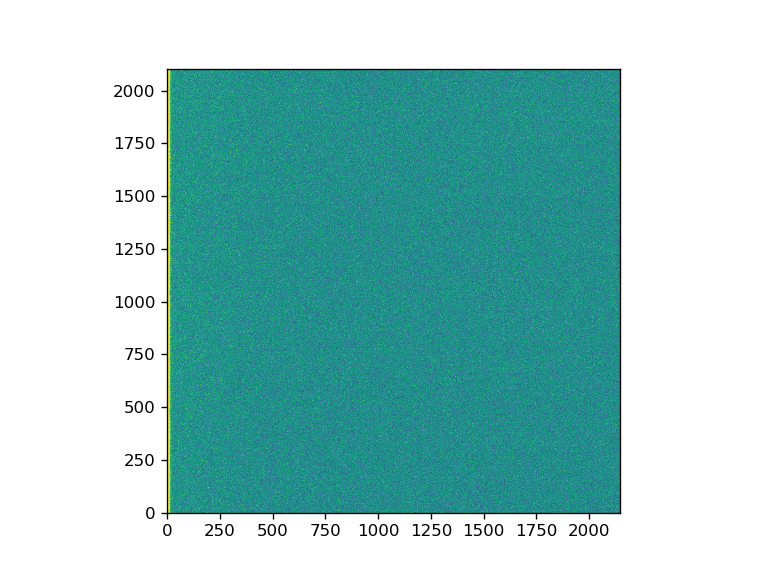

In [27]:
# Plotting one bias frame as an example
b = bias_array[0]
plt.figure()
plt.imshow(b, origin='lower', vmin=np.median(b)-2*np.std(b), vmax =np.median(b)+2*np.std(b))

# Combining the bias frames into the Master Bias   

<IPython.core.display.Javascript object>


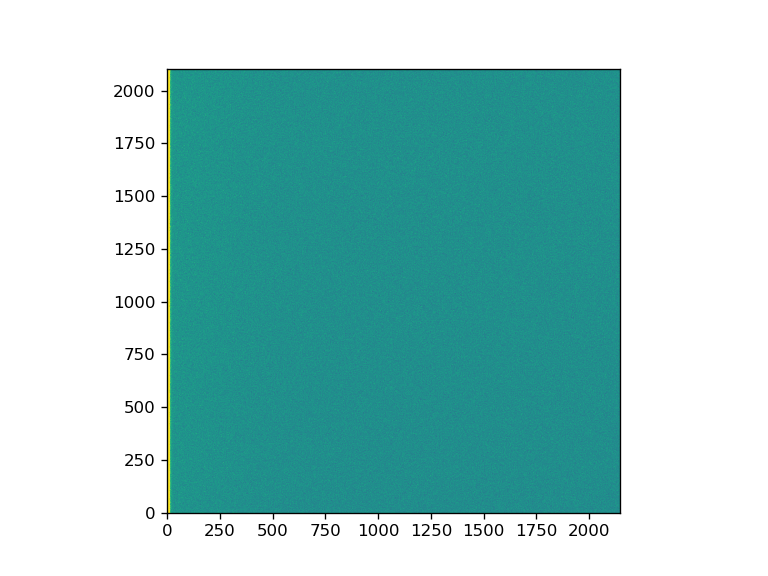

<IPython.core.display.Javascript object>


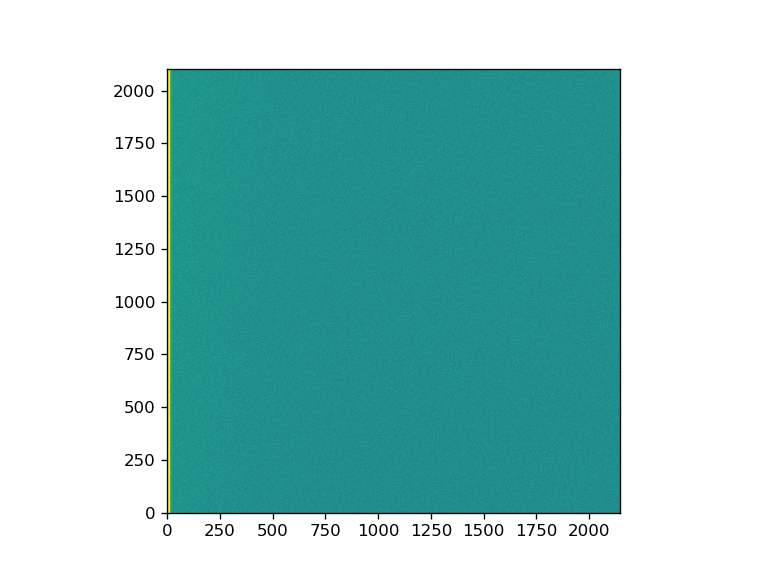

In [36]:
# Computing the master bias using a function defined in data_reduction.py module
# Two methods of combination are available: (1) mean or (2) median
master_bias1 = get_master_bias(bias_array, method="mean", n_clip=2)
master_bias2 = get_master_bias(bias_array, method="median", n_clip=2)

b = master_bias1
plt.figure()
plt.imshow(b, origin='lower', vmin=np.median(b)-2*np.std(b), vmax =np.median(b)+2*np.std(b))

c = master_bias2
plt.figure()
plt.imshow(c, origin='lower', vmin=np.median(c)-2*np.std(c), vmax =np.median(c)+2*np.std(c))

# Subtracting the Master Bias from all the other frames 

In [178]:
# Subtracting the master bias (mean) from all other frames that are not bias frames

for file in fnames:
    hdul = fits.open(file)
    
    if hdul[0].header['IMAGETYP'] != 'BIAS':
        hdul[1].data = hdul[1].data - masterBias1
        print("Master Bias subtracted from frame", file, "of image type:", hdul[0].header['IMAGETYP'])
        
        comment = "Master Bias subtracted on: "
        now = datetime.datetime.now()
        comment += now.strftime("%Y-%m-%d %H:%M:%S")
        hdul[0].header['HISTORY'] = comment
        hdul[0].header['COMMENT'] = comment
        
        new_file_name = file.replace(".fits", "_b.fits")
        hdul.writeto(new_file_name)
        print("New fits file created for the bias-subtracted frame:", new_file_name, "\n")
    
    hdul.close()

Master Bias subtracted from frame not2mattia/ALAe130147.fits of image type: FLAT,LAMP
New fits file created for the bias-subtracted frame: not2mattia/ALAe130147_b.fits 

Master Bias subtracted from frame not2mattia/ALAe130149.fits of image type: FLAT,LAMP
New fits file created for the bias-subtracted frame: not2mattia/ALAe130149_b.fits 

Master Bias subtracted from frame not2mattia/ALAe130132.fits of image type: OBJECT
New fits file created for the bias-subtracted frame: not2mattia/ALAe130132_b.fits 

Master Bias subtracted from frame not2mattia/ALAe130155.fits of image type: OBJECT
New fits file created for the bias-subtracted frame: not2mattia/ALAe130155_b.fits 

Master Bias subtracted from frame not2mattia/ALAe130145.fits of image type: OBJECT
New fits file created for the bias-subtracted frame: not2mattia/ALAe130145_b.fits 

Master Bias subtracted from frame not2mattia/ALAe130146.fits of image type: WAVE,LAMP
New fits file created for the bias-subtracted frame: not2mattia/ALAe13014